In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.feature_selection import mutual_info_classif


In [11]:
# Load the data
try:
    data = pd.read_csv('KDDTest.txt', header=None)
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")
    exit(1)
except Exception as e:
    print(f"An error occurred while loading the data: {str(e)}")
    exit(1)

In [12]:
# Define columns based on provided structure
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level'
]
data.columns = columns

In [13]:
# Convert categorical columns to numerical using LabelEncoder
label_encoders = {}
for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [14]:
# Binary classification for 'attack' column: 'normal' as 0 and others as 1
data['attack'] = data['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [15]:
# Split features and target
X = data.drop(['attack'], axis=1)
y = data['attack']

In [16]:
# Add noise to the features
noise = np.random.normal(0, 0.5, X.shape)  # Add Gaussian noise with higher standard deviation
X_noisy = X + noise

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.3, random_state=42)

In [18]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# KNN Classifier with GridSearchCV to reduce accuracy
param_grid = {
    'n_neighbors': [1, 2],  # Smaller values for n_neighbors to increase sensitivity to noise
    'weights': ['uniform'],  # Uniform weights
    'metric': ['euclidean']  # Euclidean metric
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean'], 'n_neighbors': [1, 2],
                         'weights': ['uniform']},
             verbose=2)

In [20]:
# Best model from GridSearchCV
knn = grid.best_estimator_
y_pred = knn.predict(X_test)


In [21]:
# Evaluation
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9187579214195184
Accuracy: 0.9229745712596097
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2922
           1       0.95      0.92      0.93      3842

    accuracy                           0.92      6764
   macro avg       0.92      0.92      0.92      6764
weighted avg       0.92      0.92      0.92      6764

Confusion Matrix:
 [[2721  201]
 [ 320 3522]]
ROC AUC: 0.9239607729119523


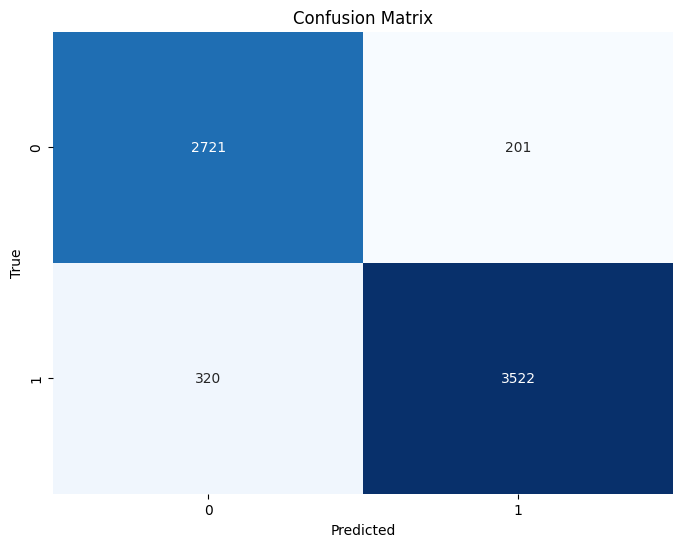

In [22]:
# Confusion Matrix with annotations
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


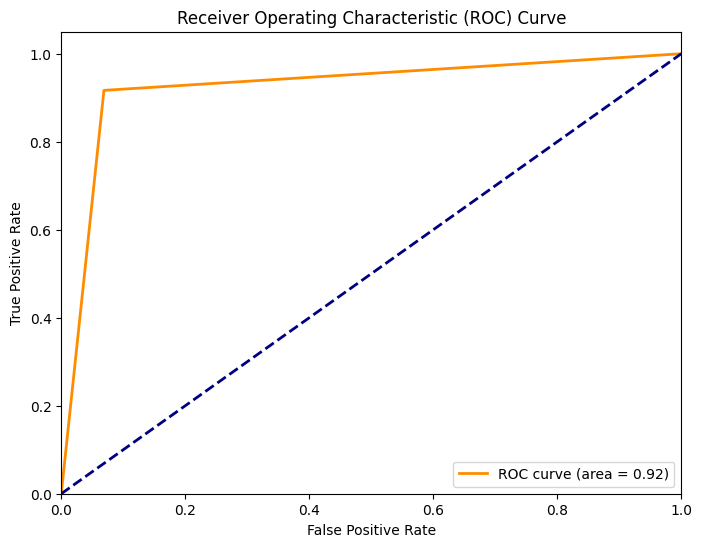

In [23]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

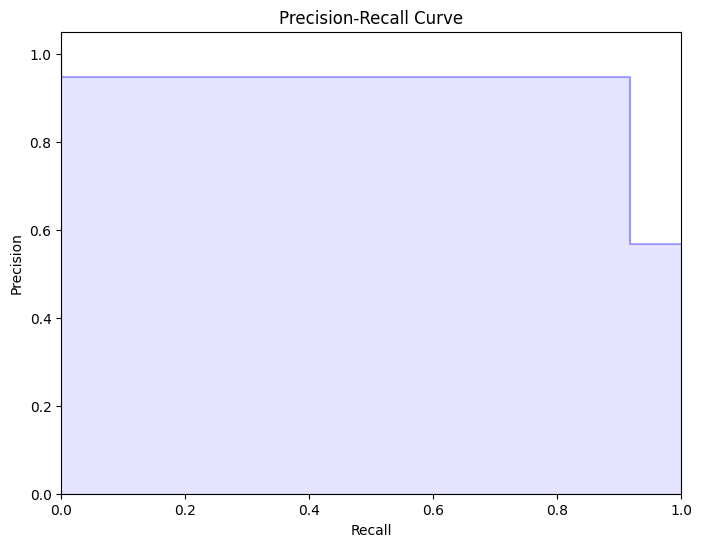

In [24]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.3, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.1, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

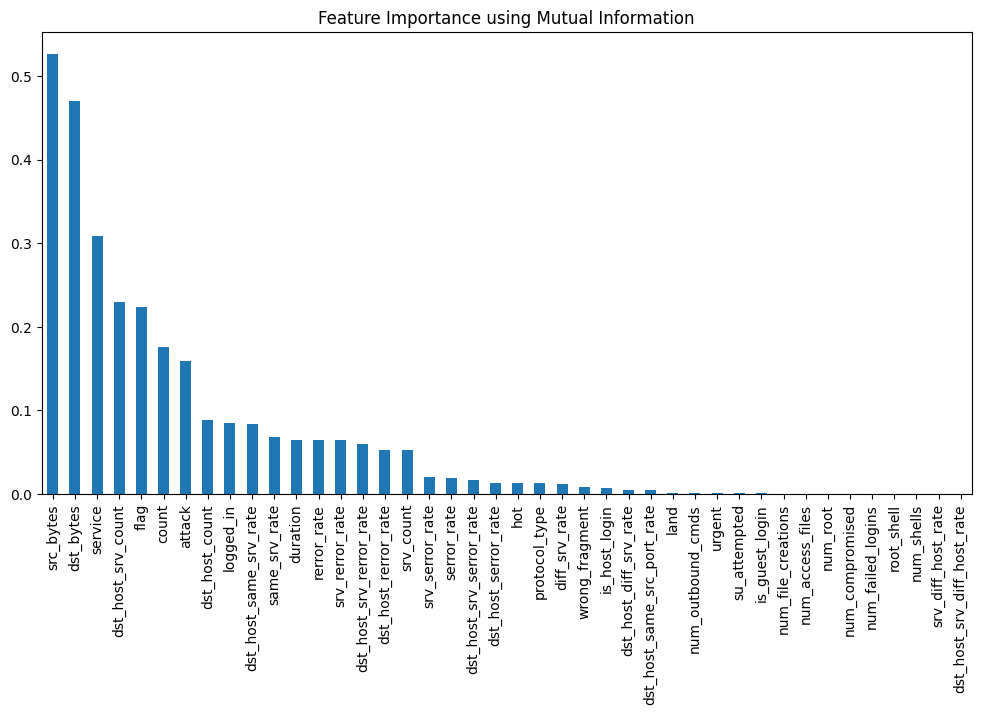

In [25]:
# Feature Importance using Mutual Information
mutual_info = mutual_info_classif(X_noisy, y)
mutual_info_series = pd.Series(mutual_info, index=columns[:-1])
mutual_info_series.sort_values(ascending=False).plot.bar(figsize=(12, 6))
plt.title('Feature Importance using Mutual Information')
plt.show()


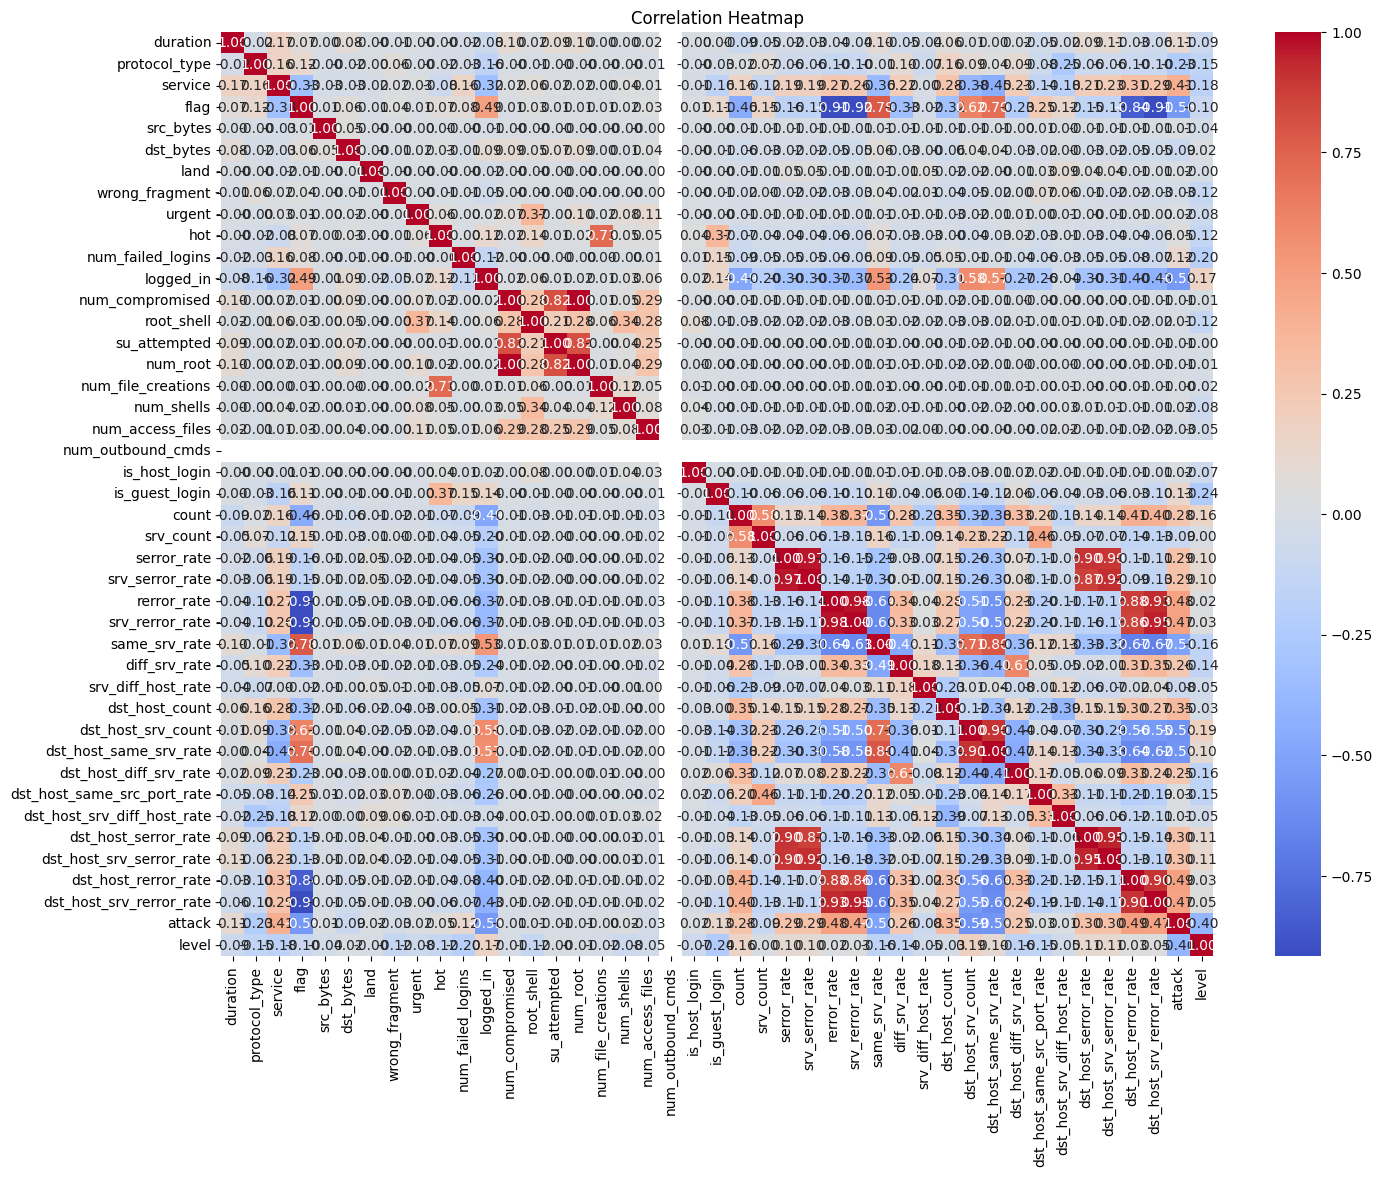

In [26]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


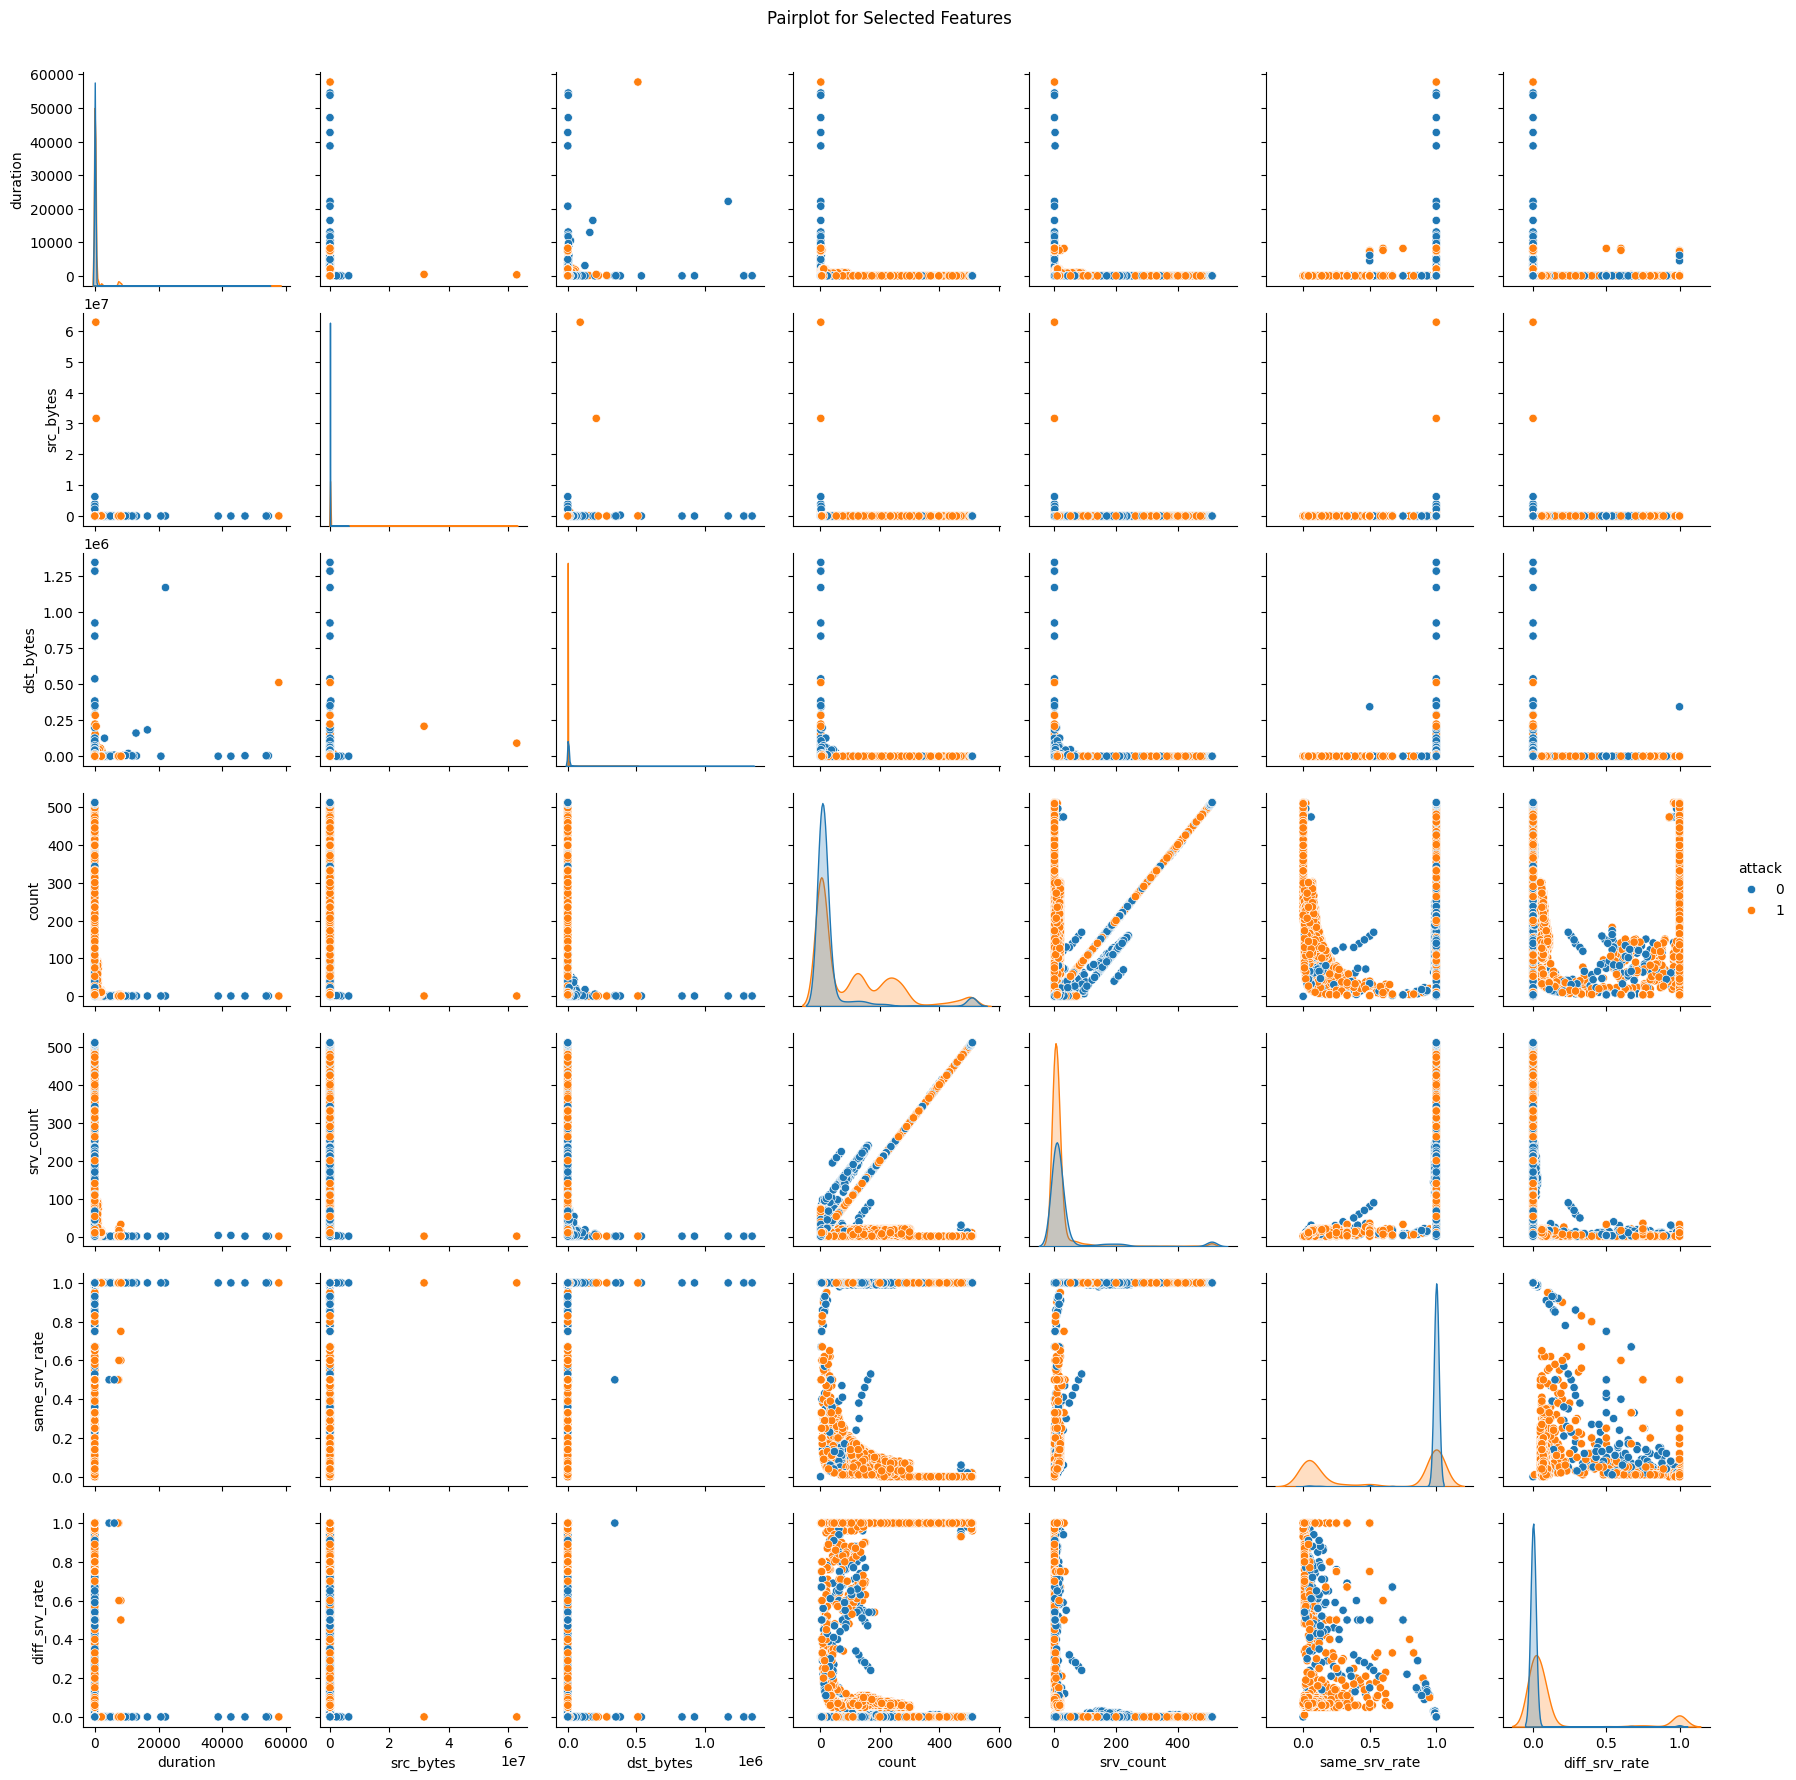

In [27]:
# Pairplot for selected features
selected_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'same_srv_rate', 'diff_srv_rate', 'attack']
sns.pairplot(data[selected_features], hue='attack', diag_kind='kde')
plt.suptitle('Pairplot for Selected Features', y=1.02)
plt.show()
